# DiffuserCam - Plenoxel - multiplexing demo
By Ruiming Cao, 11/3/2022
Updated by Vi Tran

In [117]:
%matplotlib widget
import math
import random
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
%matplotlib inline
import glob
import os
from ipywidgets import interact, IntSlider

# Parameters

In [121]:
# sensor parameters:
dim_yx = [800, 800]
dx = 0.020  # pixel size in mm

# microlens array
num_lenses_yx =  [10,10] #[2,1] #[1,1]# [4,4] #[1,1]# [4,4]
d_lens_sensor_lf = 10  # distance between lens array and sensor when no multiplexing (lightfield), in mm
dim_lens_lf_yx = [80, 80] #[200, 200]  #[400, 400]  #[200, 200]  # [80  0, 800]  # [800,800]#[200, 200]# number of pixels corresponding to a microlens at the lightfield situation
d_lenses = 1.6# distance between the centers of adjacent microlenses, in mm

# Lens - Sensor
Note: 
comap_yx stores the mapping between any pixel on the sensor and the pixels corresponding to microlenses.

E.g., the pixel at (x=a, y=b) coord on the sensor corresponds to the pixel (x=comap_yx[i, b, a, 1], y=comap_yx[i, b, a, 0]) for the microlens i. -1 means the microlens does not contribute to that pixel.

See the visualization section for an example.

In [122]:
d_lens_sensor = 15  # this is the value to change for more or less multiplexing

lenses_loc_yx = np.meshgrid((np.arange(num_lenses_yx[0]) - (num_lenses_yx[0]-1)/2) * d_lenses,
                            (np.arange(num_lenses_yx[1]) - (num_lenses_yx[1]-1)/2) * d_lenses, indexing='ij')
lenses_loc_yx = np.array(lenses_loc_yx).reshape(2, np.prod(num_lenses_yx)).transpose()

dim_lens_yx = [dim_lens_lf_yx[0] / d_lens_sensor_lf * d_lens_sensor, dim_lens_lf_yx[1] / d_lens_sensor_lf * d_lens_sensor]
dim_lens_yx = [dim_lens_yx[0] - dim_lens_yx[0]%2, dim_lens_yx[1] - dim_lens_yx[1]%2]  # assuming dim_lens_yx is even
lens_sensor_ind_yx = np.array(np.meshgrid(np.arange(dim_lens_yx[0]), np.arange(dim_lens_yx[1]), indexing='ij')).transpose((1, 2, 0))

sensor_pixel_loc_y = (np.arange(dim_yx[0]) - dim_yx[0]/2) * dx
sensor_pixel_loc_x = (np.arange(dim_yx[1]) - dim_yx[1]/2) * dx

comap_yx = -np.ones((len(lenses_loc_yx), dim_yx[0], dim_yx[1], 2))  

for i, lens_loc_yx in enumerate(lenses_loc_yx):
    center_index_yx = [np.argmin(np.abs(lens_loc_yx[0] - sensor_pixel_loc_y)), np.argmin(np.abs(lens_loc_yx[1] - sensor_pixel_loc_x))]
    start_index_sensor_yx = [np.maximum(0, center_index_yx[0] - dim_lens_yx[0]//2).astype(int),
                             np.maximum(0, center_index_yx[1] - dim_lens_yx[1]//2).astype(int)]
    end_index_sensor_yx = [np.minimum(dim_yx[0], center_index_yx[0] + dim_lens_yx[0]//2).astype(int),
                           np.minimum(dim_yx[1], center_index_yx[1] + dim_lens_yx[1]//2).astype(int)]  

    start_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + start_index_sensor_yx[0]), 
                           int(dim_lens_yx[1]//2 - center_index_yx[1] + start_index_sensor_yx[1])]
    end_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + end_index_sensor_yx[0]), 
                         int(dim_lens_yx[1]//2 - center_index_yx[1] + end_index_sensor_yx[1])]

    comap_yx[i, start_index_sensor_yx[0]:end_index_sensor_yx[0], start_index_sensor_yx[1]:end_index_sensor_yx[1], :] = lens_sensor_ind_yx[start_index_lens_yx[0]:end_index_lens_yx[0], start_index_lens_yx[1]:end_index_lens_yx[1],:]

# Visualization

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

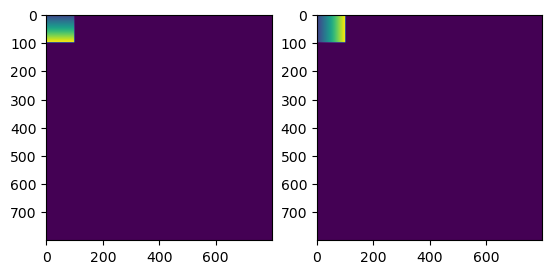

In [123]:
f, axes = plt.subplots(1, 2)
frames = []
def init():
    frames.append(axes[0].imshow(comap_yx[0, :, :, 0]))  # y coord
    frames.append(axes[1].imshow(comap_yx[0, :, :, 1]))  # x coord

init()
def updateFrames(i):
    frames[0].set_data(comap_yx[i, :, :, 0])
    frames[1].set_data(comap_yx[i, :, :, 1])
    
interact(updateFrames, i=IntSlider(min=0, max=len(lenses_loc_yx)-1, step=1, value=0))

# Generating multiplexed dataset

Randomly blockout some lenslet, set to empty list if using the full the microlenses grid

In [125]:
blocked_lenslet = random.sample(list(range(100)), k=50) #or []
print(blocked_lenslet) 

[18, 95, 65, 5, 15, 64, 33, 70, 49, 47, 80, 96, 8, 35, 54, 74, 97, 2, 83, 84, 88, 25, 19, 23, 63, 37, 28, 87, 75, 72, 20, 81, 53, 9, 22, 29, 0, 85, 16, 27, 99, 82, 71, 3, 44, 57, 98, 50, 58, 4]


Calculated how the maximum number of rays from microlens that maps to one sensor pixel

In [127]:
MAX_PER_PIXEL = 20
NUM_LENS= num_lenses_yx[0] * num_lenses_yx[1]

def get_rays_per_pixel(H,W, comap_yx):
    per_pixel = np.zeros((800,800,MAX_PER_PIXEL,3)).astype(np.uint32)
    mask = np.zeros((800,800,MAX_PER_PIXEL)).astype(float)
    cnt = np.zeros((800,800)).astype(np.uint8)
    for a in range(800):
        for b in range(800):
            for l in range(NUM_LENS):
                if l in blocked_lenslet:
                    continue
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]
                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt[a,b]] = 1.
                    cnt[a,b]+=1
    return per_pixel, mask,cnt
per_pixel, mask,cnt = get_rays_per_pixel(800,800, comap_yx)
print(np.max(cnt))

[32. 32.]
4


Generate multiplexed images, set dir_name to be the save directory

[32. 32.]


<ipython-input-128-16e3d911e360>:104: RuntimeWarning: invalid value encountered in divide
  rgb0[i_index,j_index] = rgb[i_index,j_index] / cnt_mpp[i_index, j_index] # cnt_subpixels[i_index, j_index]


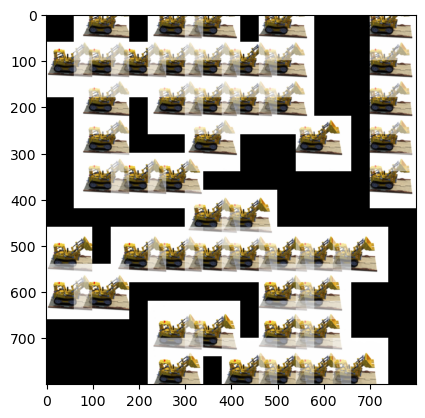

In [128]:
dir_name = "/home/vitran/plenoxels/blender_data/lego_gen10/multilens_100_dls_18_blocked_lenslet2"
os.makedirs(dir_name, exist_ok=True)

MAX_PER_PIXEL = np.max(cnt)

def max_overlapping_pixels(comap_yx):
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(800,800, comap_yx)
    rgb = np.zeros((800,800,3))
    sub_pixels = np.zeros((800,800,MAX_PER_PIXEL,3))
    cnt_pixels = np.zeros((800,800)).astype(np.int)
    for i_index in range(800):
        for j_index in range(800):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens

                cnt = cnt_pixels[i_index, j_index]
                sub_pixels[i_index, j_index, cnt] = np.array([x_index, y_index, l_index])
                cnt_pixels[i_index, j_index] += 1
    return sub_pixels, cnt_pixels


def generate(comap_yx,base):
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(800,800, comap_yx)
    u = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)) +1)
    sub_lens = np.zeros((NUM_LENS,u,u,3))
    # sub_lens = np.zeros((NUM_LENS,dim_lens_lf_yx[0],dim_lens_lf_yx[0],3))
    f = open(r'./overlapping_pixels.txt', 'w')
    cnt = 0
    for j in range(MAX_PER_PIXEL):
        im_gt = imageio.imread(f"/home/vitran/plenoxels/jax_logs10/original2/r_{base}_{j}.png").astype(np.float32) / 255.0

        a = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)))+1
        im_gt = resize(im_gt, (a,a), anti_aliasing=True)
        sub_lens[cnt,:,:,:] = im_gt[:,:,:3]
        f.write(f'pixel value {np.sum(sub_lens[cnt,:,:,0])}\n')

        cnt+=1
    rgb0 = np.zeros((800,800,3)).astype(float)
    rgb = np.zeros((800,800,3)).astype(float)
    cnt_subpixels = np.zeros((800,800), dtype=int)
    
    for i_index in range(800):
        for j_index in range(800):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens

                if mask[i_index, j_index,cnt_rays]==1:
                    rgb[i_index, j_index] += sub_lens[l_index, x_index, y_index,:]
                    cnt_subpixels[i_index, j_index] +=1
                    
            rgb0[i_index,j_index] = rgb[i_index,j_index] / cnt_mpp[i_index, j_index] # cnt_subpixels[i_index, j_index]
            f.write(f'before {rgb[i_index,j_index, 0]} after {rgb0[i_index,j_index,0] }\n')

    f.write(f'SUM {np.sum(rgb[:,:,0])}')
    for m in range(100,200,1):
        for n in range(100,200,1):
            f.write(f'subtract pixels sensor {rgb[m,n,:] - rgb0[m,n,:] }\n')
    rgb = rgb0
    rgb = np.concatenate((rgb, np.ones((800,800,1))), axis=2)
    f.close()
    return rgb

for base in range(0,10,1):
    rgb = generate(comap_yx, base)
    
    rgb = Image.fromarray((rgb*255).astype('uint8')) #(a*255).astype('uint8'))
    plt.imshow(rgb)
    rgb.save(f"{dir_name}/r_{base}.png")


Generate the json file points to the newly generated multiplexed images

In [ ]:
file = open('/home/vitran/plenoxels/blender_data/lego_gen10/transforms_train_multilens_100.json')
org_json = json.load(file)
new_frames = []
for i, frame in enumerate(org_json['frames']):
    frame['file_path'] = f'./multilens_100_dls_15_blocked_lenslet2/r_{i}'
    new_frames.append(frame)

file.close()
org_json['frames'] = new_frames
with open(f'/home/vitran/plenoxels/blender_data/lego_gen10/transforms_multilens_100_dls_15_blocked_lenslet2.json','w') as f:
    json.dump(org_json, f)